In [4]:
# Convenience and saving
ABRIDGED_RUN = False # Set to True to train and validate on 10% of the data, for quick funcitonality tests etc
SAVE_AFTER_TRAINING = True # Save the model when you are done
SAVE_CHECKPOINTS = True # Save the model after every epoch
REPORT_TRAINING_LOSS_PER_EPOCH = True # Track the training loss each epoch, and write it to a file after training
REPORT_VALIDATION_LOSS_PER_EPOCH = True # Lets us make a nice learning curve after training

# Training hyperparameters
BATCH_SIZE = 256 # Number of samples per batch while training our network
NUM_EPOCHS = 20 # Number of epochs to train our network
LEARNING_RATE = 0.001 # Learning rate for our optimizer

# Directories
DATA_DIR = "../data/"
AUDIO_DIR = DATA_DIR + "train_audio/"
AUDIO_DIR_DCASE = DATA_DIR + "wav/"
AUDIO_DIR_2021 = DATA_DIR + "train_soundscapes_2021/"
CHECKPOINT_DIR = "checkpoints/" # Checkpoints, models, and training data will be saved here
MODEL_NAME = "BIRDCALL_DETECTION_DCASE_ALL_DATA"

# Preprocessing info
SAMPLE_RATE = 32000 # All our audio uses this sample rate
SAMPLE_LENGTH = 5 # Duration we want to crop our audio to

MIN_SAMPLE_LENGTH = 3.5 # Only use samples with length >= 3.5 seconds
MAX_SAMPLE_LENGTH = 120 # Trim every sample to <= 120 seconds


In [5]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import librosa
import os
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from pathlib import Path

In [6]:
# Torch imports
import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchaudio.transforms import MelSpectrogram, Resample
from IPython.display import Audio
import torch.optim as optim

In [39]:
class BirdCallDetector(nn.Module):
    ''' Full architecture from https://github.com/musikalkemist/pytorchforaudio/blob/main/10%20Predictions%20with%20sound%20classifier/cnn.py'''
    def __init__(self):
        super(BirdCallDetector, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(10368, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

In [40]:
CHECKPOINT_DIR + MODEL_NAME +'/final.pt'

'checkpoints/BIRDCALL_DETECTION_DCASE_ALL_DATA/final.pt'

In [41]:
device = None
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} for training")

Using cpu for training


In [42]:
model = BirdCallDetector().to(device)
model.load_state_dict(torch.load(CHECKPOINT_DIR + MODEL_NAME + '/final.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [43]:
model.eval()

BirdCallDetector(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv2d(128, 128, kerne

In [60]:
# Transforms audio signal to a spectrogram
spectrogram_transform = torchaudio.transforms.Spectrogram(
        n_fft=2048,
        win_length=2048,
        hop_length=512,
        power=2
    )

# Converts ordinary spectrogram to Mel scale
mel_spectrogram_transform = torchaudio.transforms.MelScale(
    n_mels=256,
    sample_rate=SAMPLE_RATE,
    f_min=0,
    f_max=16000,
    n_stft=1025  # the number of frequency bins in the spectrogram
)

# Scales decibels to reasonable level (apply to a spectrogram or Mel spectrogram)
db_scaler = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)

# Resizes spectrograms into square images
resize = transforms.Resize((224, 224), antialias = None)

# Applies a frequency mask to a spectrogram
def freq_mask(spec, F=30):
    num_mel_channels = spec.shape[1]
    f = random.randrange(0, F)
    f_zero = random.randrange(0, num_mel_channels - f)
    spec[:, f_zero:f_zero+f, :] = 0
    return spec

# Applies a time mask to a spectrogram
def time_mask(spec, T=40):
    spec_len = spec.shape[2]
    t = random.randrange(0, T)
    t_zero = random.randrange(0, spec_len - t)
    spec[:, :, t_zero:t_zero+t] = 0
    return spec

In [12]:
def slices(seq, window_size = SAMPLE_RATE*SAMPLE_LENGTH, stride = None, align_left = True, return_scraps = True):
    # If one window is larger than the sequence, just return the scraps or nothing
    if window_size > seq.shape[0]:
        if return_scraps == True:
            return [seq]
        else:
            return []
    # If stride is None, it defaults to window_size
    if stride == None:
        stride = window_size
    index_slices = []
    left_pointer = 0
    while left_pointer + window_size <= seq.shape[0]:
        index_slices += [[left_pointer, left_pointer + window_size]]
        left_pointer += stride
    if align_left == False:
        offset = seq.shape[0]-(left_pointer-stride)-window_size
        index_slices = [[a+offset, b+offset] for [a,b] in index_slices]
    if return_scraps == True and left_pointer < seq.shape[0]:
        if align_left == True:
            index_slices += [[left_pointer, seq.shape[0]]]
        else:
            index_slices += [[0, seq.shape[0] - left_pointer]]
    return [seq[a:b] for [a,b] in index_slices]

In [13]:
class DCaseData(Dataset):
    def __init__(self, signals, labels, training = True,
        config = {'use_mel': True, 'time_mask': True, 'freq_mask': True}):
        super().__init__()
        self.training = training
        self.config = config
        print(f'Preprocessing {"training" if training else "validation"} data\n')
        self.processed_clips, self.labels = self.process(signals, labels)
    def process(self, signals, labels):
        results = []
        new_labels = []
        for i, signal in enumerate(signals):
            # Uniformize to 5 seconds
            if signal.shape[1] < SAMPLE_RATE * SAMPLE_LENGTH:
                pad_length = SAMPLE_RATE * SAMPLE_LENGTH - signal.shape[1]
                signal = torch.nn.functional.pad(signal, (0, pad_length))
            # Cut signal into 5 second chunks to save
            for clip in slices(signal.squeeze()):
                results += [clip.unsqueeze(0)]
                new_labels += [labels[i]]
        return results, new_labels
    def __len__(self):
        return len(self.processed_clips)
    def __getitem__(self, index):
        # Process clip to tensor
        x = self.processed_clips[index]
        x = spectrogram_transform(x)
        if self.config['use_mel']:
            x = mel_spectrogram_transform(x)
        x = db_scaler(x)
        if self.config['time_mask'] and self.training:
            x = time_mask(x)
        if self.config['freq_mask'] and self.training:
            x = freq_mask(x)
        x = resize(x)
        return x, self.labels[index]

In [15]:
dcase = pd.read_csv(DATA_DIR+'ff1010bird_metadata_2018.csv')

In [22]:
dcase = dcase.iloc[:5,:]

In [24]:
dcase['filepath'] = AUDIO_DIR_DCASE + dcase['itemid'].astype(str)+'.wav'

In [18]:
def filepath_to_signal(filepath):
    sample, sr = torchaudio.load(filepath)
    # Resampling to desired sample rate
    sample = torchaudio.functional.resample(sample, orig_freq = sr, new_freq = SAMPLE_RATE)
    return sample

In [26]:
dcase['signal'] = dcase['filepath'].apply(filepath_to_signal)

In [27]:
validation_dataset =  DCaseData(signals = dcase['signal'].to_list(), 
                                labels = dcase['hasbird'].to_list(),
                                training = False)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

Preprocessing validation data



  0%|          | 0/5 [00:00<?, ?it/s]

In [38]:
preds = []
target = []
for validation_data in validation_dataloader:
            inputs, labels = validation_data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds += [output[1].item() for output in outputs]
            target += [label.item() for label in labels]

In [39]:
print(preds)
print('\n')
print('\n')
print(target)

[0.0013609020970761776, 0.0033772734459489584, 0.00048743459046818316, 0.0031949894037097692, 0.003915158100426197, 0.001928273937664926, 0.0002775616303551942, 0.00033905249438248575, 0.7415745854377747, 0.4081900715827942]




[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [40]:
from torcheval.metrics import BinaryAUROC

In [42]:
metric = BinaryAUROC()
metric.update(torch.tensor(preds), torch.tensor(target))
metric.compute()

tensor(0.5000, dtype=torch.float64)

In [43]:
predsframe = pd.read_csv('/Users/ashwintan/Downloads/preds_birdCLEF2021.csv')

In [49]:
predsframe = predsframe.loc[:,['preds', 'target']]

In [51]:
predsframe.head()

,preds,target
0,0.045357,0
1,0.002481,0
2,0.004913,0
3,0.002550,0
4,0.000199,0


In [52]:
from sklearn.metrics import accuracy_score

In [62]:
acc_scores = [None]*100
thresholds = [0.01*i for i in range(100)]
for i in range(100):
    pred_labels = [0 if pred <= thresholds[i] else 1 for pred in predsframe['preds']]
    target_labels = predsframe['target'].to_list()
    acc_scores[i] = accuracy_score(target_labels, pred_labels)


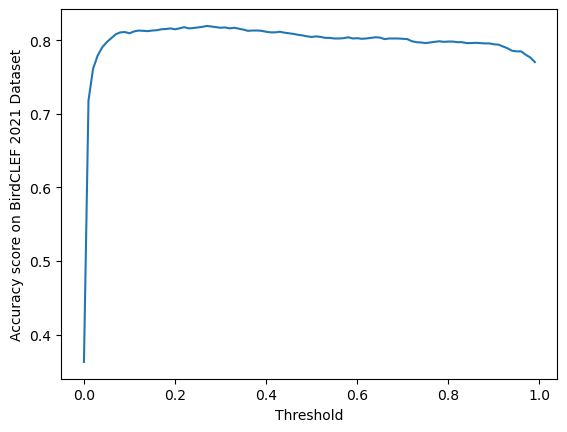

In [69]:
plt.figure()
plt.plot(thresholds, acc_scores)
plt.ylabel('Accuracy score on BirdCLEF 2021 Dataset')
plt.xlabel('Threshold')
plt.show()

In [64]:
print(acc_scores)

[0.36291666666666667, 0.7183333333333334, 0.76125, 0.7791666666666667, 0.7904166666666667, 0.7975, 0.8029166666666666, 0.8083333333333333, 0.8108333333333333, 0.81125, 0.8095833333333333, 0.8120833333333334, 0.8133333333333334, 0.8129166666666666, 0.8125, 0.8133333333333334, 0.81375, 0.815, 0.8154166666666667, 0.81625, 0.815, 0.81625, 0.8179166666666666, 0.81625, 0.8166666666666667, 0.8175, 0.8183333333333334, 0.8195833333333333, 0.81875, 0.8179166666666666, 0.8170833333333334, 0.8175, 0.81625, 0.8170833333333334, 0.8158333333333333, 0.8145833333333333, 0.8129166666666666, 0.8133333333333334, 0.8133333333333334, 0.8129166666666666, 0.8116666666666666, 0.8108333333333333, 0.8108333333333333, 0.8116666666666666, 0.8104166666666667, 0.8095833333333333, 0.80875, 0.8075, 0.8066666666666666, 0.8054166666666667, 0.8045833333333333, 0.8054166666666667, 0.8045833333333333, 0.8033333333333333, 0.8033333333333333, 0.8025, 0.8025, 0.8029166666666666, 0.8041666666666667, 0.8025, 0.8029166666666666,

In [65]:
max(range(100), key = acc_scores.__getitem__)

27

In [66]:
acc_scores[50]

0.8045833333333333

In [67]:
acc_scores[27]

0.8195833333333333

In [7]:
data = pd.read_csv(DATA_DIR+"full_metadata.csv")
data.head()

,Unnamed: 0,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,duration
0,0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,27.350219
1,1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,15.804094
2,2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,29.257156
3,3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,14.158375
4,4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,47.882438


In [8]:
data['filepath'] = AUDIO_DIR + data['filename']
data = data[['filepath', 'primary_label', 'duration']]
data.head()

,filepath,primary_label,duration
0,../data/train_audio/asbfly/XC134896.ogg,asbfly,27.350219
1,../data/train_audio/asbfly/XC164848.ogg,asbfly,15.804094
2,../data/train_audio/asbfly/XC175797.ogg,asbfly,29.257156
3,../data/train_audio/asbfly/XC207738.ogg,asbfly,14.158375
4,../data/train_audio/asbfly/XC209218.ogg,asbfly,47.882438


In [9]:
species = ['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2', 'asiope1', 'aspfly1', 'aspswi1', 'barfly1', 'barswa', 'bcnher', 'bkcbul1', 'bkrfla1', 'bkskit1', 'bkwsti', 'bladro1', 'blaeag1', 'blakit1', 'blhori1', 'blnmon1', 'blrwar1', 'bncwoo3', 'brakit1', 'brasta1', 'brcful1', 'brfowl1', 'brnhao1', 'brnshr', 'brodro1', 'brwjac1', 'brwowl1', 'btbeat1', 'bwfshr1', 'categr', 'chbeat1', 'cohcuc1', 'comfla1', 'comgre', 'comior1', 'comkin1', 'commoo3', 'commyn', 'compea', 'comros', 'comsan', 'comtai1', 'copbar1', 'crbsun2', 'cregos1', 'crfbar1', 'crseag1', 'dafbab1', 'darter2', 'eaywag1', 'emedov2', 'eucdov', 'eurbla2', 'eurcoo', 'forwag1', 'gargan', 'gloibi', 'goflea1', 'graher1', 'grbeat1', 'grecou1', 'greegr', 'grefla1', 'grehor1', 'grejun2', 'grenig1', 'grewar3', 'grnsan', 'grnwar1', 'grtdro1', 'gryfra', 'grynig2', 'grywag', 'gybpri1', 'gyhcaf1', 'heswoo1', 'hoopoe', 'houcro1', 'houspa', 'inbrob1', 'indpit1', 'indrob1', 'indrol2', 'indtit1', 'ingori1', 'inpher1', 'insbab1', 'insowl1', 'integr', 'isbduc1', 'jerbus2', 'junbab2', 'junmyn1', 'junowl1', 'kenplo1', 'kerlau2', 'labcro1', 'laudov1', 'lblwar1', 'lesyel1', 'lewduc1', 'lirplo', 'litegr', 'litgre1', 'litspi1', 'litswi1', 'lobsun2', 'maghor2', 'malpar1', 'maltro1', 'malwoo1', 'marsan', 'mawthr1', 'moipig1', 'nilfly2', 'niwpig1', 'nutman', 'orihob2', 'oripip1', 'pabflo1', 'paisto1', 'piebus1', 'piekin1', 'placuc3', 'plaflo1', 'plapri1', 'plhpar1', 'pomgrp2', 'purher1', 'pursun3', 'pursun4', 'purswa3', 'putbab1', 'redspu1', 'rerswa1', 'revbul', 'rewbul', 'rewlap1', 'rocpig', 'rorpar', 'rossta2', 'rufbab3', 'ruftre2', 'rufwoo2', 'rutfly6', 'sbeowl1', 'scamin3', 'shikra1', 'smamin1', 'sohmyn1', 'spepic1', 'spodov', 'spoowl1', 'sqtbul1', 'stbkin1', 'sttwoo1', 'thbwar1', 'tibfly3', 'tilwar1', 'vefnut1', 'vehpar1', 'wbbfly1', 'wemhar1', 'whbbul2', 'whbsho3', 'whbtre1', 'whbwag1', 'whbwat1', 'whbwoo2', 'whcbar1', 'whiter2', 'whrmun', 'whtkin2', 'woosan', 'wynlau1', 'yebbab1', 'yebbul3', 'zitcis1']
species_to_index = {species[i]:i for i in range(len(species))}
data['index_label'] = data['primary_label'].apply(lambda x: species_to_index[x])

In [10]:
data['tensor_label'] = pd.Series(pd.get_dummies(data['primary_label']).astype(int).values.tolist()).apply(lambda x: torch.Tensor(x))

In [11]:
data.head()

,filepath,primary_label,duration,index_label,tensor_label
0,../data/train_audio/asbfly/XC134896.ogg,asbfly,27.350219,0,"[tensor(1.), tensor(0.), tensor(0.), tensor(0...."
1,../data/train_audio/asbfly/XC164848.ogg,asbfly,15.804094,0,"[tensor(1.), tensor(0.), tensor(0.), tensor(0...."
2,../data/train_audio/asbfly/XC175797.ogg,asbfly,29.257156,0,"[tensor(1.), tensor(0.), tensor(0.), tensor(0...."
3,../data/train_audio/asbfly/XC207738.ogg,asbfly,14.158375,0,"[tensor(1.), tensor(0.), tensor(0.), tensor(0...."
4,../data/train_audio/asbfly/XC209218.ogg,asbfly,47.882438,0,"[tensor(1.), tensor(0.), tensor(0.), tensor(0...."


In [12]:
data = data[data['duration'] >= MIN_SAMPLE_LENGTH]

In [13]:
data = data.sample(100)

In [14]:
data.head()

,filepath,primary_label,duration,index_label,tensor_label
21105,../data/train_audio/rossta2/XC755715.ogg,rossta2,11.179094,144,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
22995,../data/train_audio/whiter2/XC381842.ogg,whiter2,28.447344,174,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
21544,../data/train_audio/spepic1/XC802723.ogg,spepic1,59.640000,154,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
7508,../data/train_audio/comsan/XC579400.ogg,comsan,5.093000,44,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
6269,../data/train_audio/commoo3/XC618889.ogg,commoo3,14.158000,40,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [79]:
data.loc[21105, 'tensor_label'].shape

torch.Size([182])

In [80]:
zeros = torch.zeros(182)
zeros.shape

torch.Size([182])

In [84]:
zeros.sum()

tensor(0.)

In [ ]:
class BirdCallDetector(nn.Module):
    ''' Full architecture from https://github.com/musikalkemist/pytorchforaudio/blob/main/10%20Predictions%20with%20sound%20classifier/cnn.py'''
    def __init__(self):
        super(BirdCallDetector, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(10368, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

In [17]:
def filepath_to_signal(filepath):
    signal, _ = torchaudio.load(filepath)
    if signal.shape[1] < SAMPLE_RATE * SAMPLE_LENGTH:
        pad_length = SAMPLE_RATE * SAMPLE_LENGTH - signal.shape[1]
        signal = torch.nn.functional.pad(signal, (0, pad_length))
    return signal

In [19]:
signal = filepath_to_signal(data.loc[21105, 'filepath'])

In [20]:
signal

tensor([[-4.7997e-03, -5.9278e-03, -4.5872e-03,  ..., -1.6410e-05,
         -1.1244e-05, -9.9803e-06]])

In [1]:
def generate_pink_noise(samples):
    b = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
    a = [1, -2.494956002, 2.017265875, -0.522189400]

    pink_noise = np.random.randn(samples)
    pink_noise = np.convolve(pink_noise, b)
    pink_noise = np.convolve(pink_noise, a, mode='valid')
    return torch.Tensor(pink_noise).unsqueeze(0)

In [2]:
def add_pink_noise(signal, snr):
    pink = generate_pink_noise(signal.shape[1])
    return torchaudio.functional.add_noise(signal, pink, torch.Tensor([snr]))

In [21]:
pink = generate_pink_noise(signal.shape[1])

In [23]:
print(signal.shape)

torch.Size([1, 358592])


In [22]:
print(pink)
print('\n\n')
print(pink.shape)

tensor([[ 0.4159, -0.9910,  0.9693,  ..., -0.3631, -0.0884,  0.2061]])



torch.Size([1, 358592])


In [26]:
MAX_SNR = 20
MIN_SNR = -10

In [27]:
x = add_pink_noise(signal, np.random.uniform(low = MIN_SNR, high = MAX_SNR))
print(x, '\n', x.shape)

tensor([[-0.0056, -0.0059, -0.0035,  ...,  0.0012, -0.0017,  0.0012]]) 
 torch.Size([1, 358592])


In [28]:
signal.squeeze().shape

torch.Size([358592])

In [29]:
pad_length = 5000

In [31]:
signal2 = torch.nn.functional.pad(signal.squeeze(), (0, pad_length))

In [33]:
signal2

tensor([-0.0048, -0.0059, -0.0046,  ...,  0.0000,  0.0000,  0.0000])

In [38]:
torch.flip(signal2, [0])

tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.0046, -0.0059, -0.0048])

In [54]:
signal = signal[:, :SAMPLE_RATE*SAMPLE_LENGTH]

In [62]:
x = spectrogram_transform(signal)
x = mel_spectrogram_transform(x)
x = db_scaler(x)
x = resize(x)

In [77]:
model(x.unsqueeze(0))[0][1].item()

0.8738466501235962